# Wind Farm Power Prediction

In [1]:
# load modules (install floris)
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gpflow
import GPy
import random
from pygmo import hypervolume

# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
%matplotlib inline

import time
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

In [2]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

# Compute the maximum wind turbine power using single wind turbine 

In [3]:
#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446


## Setup Wind Farm Layout
### Open "example_input_double.json" and look at how the wind farm is defined

In [4]:
floris = Floris("example_input_double.json")

# Compute the power vector and total wind farm power

In [5]:
wd=180;
ws=8;
num_tur = len(floris.farm.flow_field.turbine_map.items())
yawAngle = np.ones(num_tur)*0.01
power, totalPower = windFarmPower(floris, wd, 8, yawAngle, powerSingle)
totalPower

array([[0.99999909]])

# Compare the greedy control and cooperative control (optimized yaw angle vector)

In [6]:
def hypervolume_poi(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1

    # Calculate Hypervolume contribution of points Y
    ub_points = np.zeros((1, num_cells*outdim))
    lb_points = np.zeros((1, num_cells*outdim))
    for i in range(len(ub_idx)):
        ub_points[0,i] = pf_ext[ub_idx[i][0],ub_idx[i][1]]
        lb_points[0,i] = pf_ext[lb_idx[i][0],lb_idx[i][1]]
    ub_points = np.reshape(ub_points, [num_cells, outdim])
    lb_points = np.reshape(lb_points, [num_cells, outdim])

    splus_valid = np.all(np.tile(np.expand_dims(ub_points, 1), [1, N, 1]) > candidate_mean,
                                axis=2)  # num_cells x N
    splus_idx = np.expand_dims(splus_valid.astype(np.float64), -1)  # num_cells x N x 1
    splus_lb = np.tile(np.expand_dims(lb_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus_lb = np.maximum(splus_lb, candidate_mean)  # num_cells x N x outdim
    splus_ub = np.tile(np.expand_dims(ub_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus = np.concatenate([splus_idx, splus_ub - splus_lb], axis=2)  # num_cells x N x (outdim+1)
    Hv = np.transpose(np.sum(np.prod(splus, axis=2), axis=0, keepdims=True))  # N x 1
    
    # return HvPoI
    return -np.multiply(Hv, PoI)

In [7]:
def sample_next_point(acquisition, gp_model, bounds, pareto, reference, outdim, wind_dir, N_mc = 5000):
    """
    acquisition : acquisition function of Gaussian processes
    gp_model : gpflow Gaussian process model
    eval_y : evaluated y list in current state
    bounds : boundary of next point
    n_restarts : number of restarts for scipy.minimize
    
    return : next x    
    """
    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, pareto, reference, outdim, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0=points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, pareto, reference, outdim, wind_dir))
    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [8]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

In [9]:
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [10]:
# Generate context
def generate_context(lower, upper, length):
    con = [np.random.uniform(lower,upper)]
    for i in range(length-1):
        add = np.random.normal(0,2)
        if con[-1] + add > upper or con[-1] + add < lower:
                new_c = con[-1] - add  
        else:
            new_c = con[-1] + add  
        con.append(new_c)
    return np.array(con)[:,None]

In [11]:
# initial data point of wind-farm
init_sample = 1
wd_init = np.random.uniform(90, 120, size=(init_sample, 1))

X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, wd_init))
Y = multiobj_f(X)

In [12]:
num_output = Y.shape[1]
num_iter = 3000
lower = 90
upper = 120
# wd_context = np.random.uniform(90, 120, size=(num_iter, 1))
wd_context = generate_context(lower, upper, num_iter)
t1 = time.time()
    
for i in range(num_iter):
    print(i)
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))

    if i == 0:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    elif i%10 != 0:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= gp_models[i].kern, noise_var = gp_models[i].likelihood[0] ) for i in range(Y.shape[1])]
    else:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= gp_models[i].kern, noise_var = gp_models[i].likelihood[0] ) for i in range(Y.shape[1])]
        for m in gp_models:
            m.optimize()
    
    trusted_X = np.array([X[j] for j in range(len(X)) if wd_context[i]-30 <= X[j,-1] <= wd_context[i]+30])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
       
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)
t2 = time.time()
print(t2-t1)

0
1
2
3
4
5
6
7
8
9
10


 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


11
12
13
14
15
16
17
18
19
20


 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290

1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


In [13]:
# Approximated Pareto set
x_coord = np.arange(0,25,0.5)
x1, x2 = np.meshgrid(x_coord, x_coord)
x = np.hstack((x1.ravel()[:,None],x2.ravel()[:,None]))
cont = np.ones((len(x),1))
for c in np.arange(90,120.5,0.5):
    pareto = Pareto(np.empty((0, num_tur)))
    if c == 90:
        C = cont * c
        X = np.hstack((x, C))
        f1 = multiobj_f(X)[:,0][:,None]
        f2 = multiobj_f(X)[:,1][:,None]
        pareto.update(multiobj_f(X))
        pareto_f1 = pareto.front[:,0][:,None]
        pareto_f2 = pareto.front[:,1][:,None]
        pareto_C = np.ones((len(pareto.front),1)) * c
    else:
        C = np.append(C, cont * c, axis = 0)
        X = np.hstack((x, cont * c))
        f1 = np.append(f1, multiobj_f(X)[:,0][:,None], axis = 0)
        f2 = np.append(f2, multiobj_f(X)[:,1][:,None], axis = 0)
        pareto.update(multiobj_f(X))
        pareto_f1 = np.append(pareto_f1, pareto.front[:,0][:,None], axis = 0)
        pareto_f2 = np.append(pareto_f2, pareto.front[:,1][:,None], axis = 0)
        pareto_C = np.append(pareto_C, np.ones((len(pareto.front),1)) * c, axis = 0)
print(len(C))
len(pareto_f1)

152500


1451

In [14]:
Y = Y[1:]

In [9]:
np.zeros(2)

array([0., 0.])

In [8]:
from visualization_manager import VisualizationManager
def visualizeWake(floris,wd, ws, yawAngle):
    floris.farm.flow_field.wind_direction = np.radians(wd) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    
    ff_viz = deepcopy(floris.farm.flow_field)
    grid_resolution = (100, 100, 25)
    visualization_manager = VisualizationManager(ff_viz, grid_resolution)
    visualization_manager.plot_z_planes([0.5])

yawAngle = np.array([0, 0])
visualizeWake(floris, 90, 8, yawAngle)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:92: RuntimeWarning:divide by zero encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:128: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:129: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:130: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:191: RuntimeWarning:divide by zero encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:120: RuntimeWarning:invalid value encountered in greater
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_deflection.py:125: RuntimeWarning:invalid value encountered in less
 /home/cwj/venv/local/lib/python3.5/site-packages/floris

ValueError: Both *x_transform* and *y_transform* must be 2D affine transforms

<Figure size 432x288 with 2 Axes>

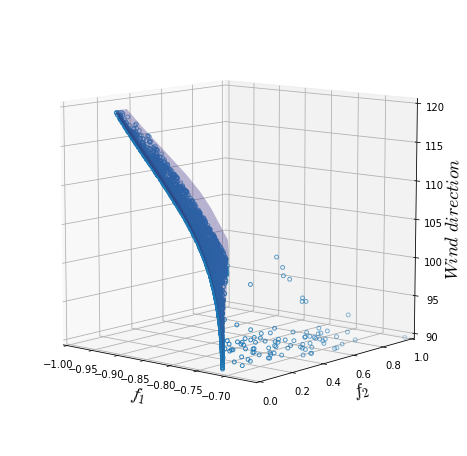

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4, zorder = 2)
ax.set_xlim([-1,-0.65])
ax.set_ylim([0,1])
ax.set_zlim([90,120])
ax.scatter(Y[:,0], Y[:,1], wd_context, s=15, label = 'Selected pts', facecolors='none', color='#1f77b4', zorder = 1)
ax.view_init(azim=310, elev=10)
ax.set_xlabel(r'$f_{1}$', fontsize=18, rotation=150)
ax.set_ylabel(r'$f_{2}$', fontsize=18)
ax.set_zlabel(r'$Wind \ direction$', fontsize=18)
plt.savefig('pareto_surface.png',bbox_inches='tight')
plt.show()


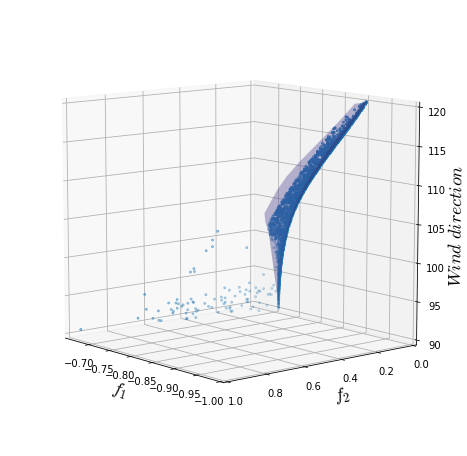

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4, zorder = 2)
ax.set_xlim([-1,-0.65])
ax.set_ylim([0,1])
ax.set_zlim([90,120])
ax.scatter(Y[:,0], Y[:,1], wd_context, s=3, label = 'Selected pts', facecolors='none', color='#1f77b4', zorder = 1)
ax.view_init(azim=140, elev=10)
ax.set_xlabel(r'$f_{1}$', fontsize=18, rotation=150)
ax.set_ylabel(r'$f_{2}$', fontsize=18)
ax.set_zlabel(r'$Wind \ direction$', fontsize=18)
plt.savefig('pareto_surface2.png',bbox_inches='tight')
plt.show()

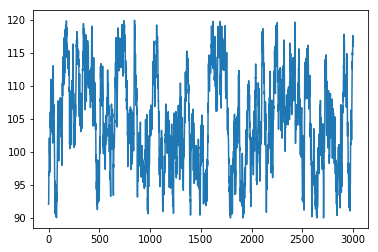

In [18]:
plt.plot(wd_context)
plt.show()

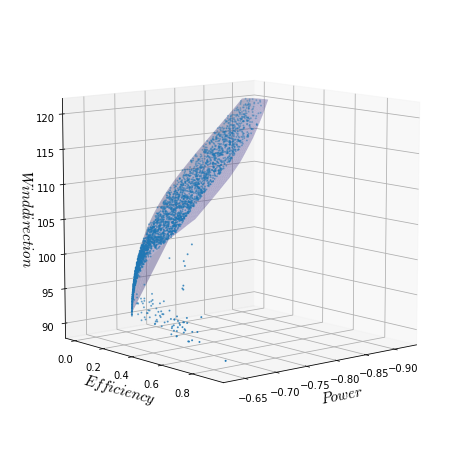

<Figure size 432x288 with 0 Axes>

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4)
ax.scatter(Y[:,0], Y[:,1], wd_context, s=1, label = 'Selected pts')
ax.view_init(azim=50, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=150)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
plt.show()
plt.savefig('pareto_surface.png')

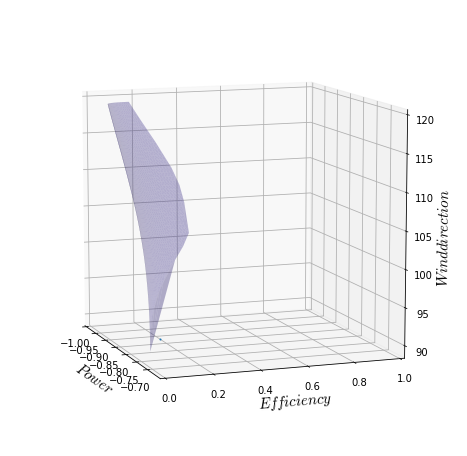

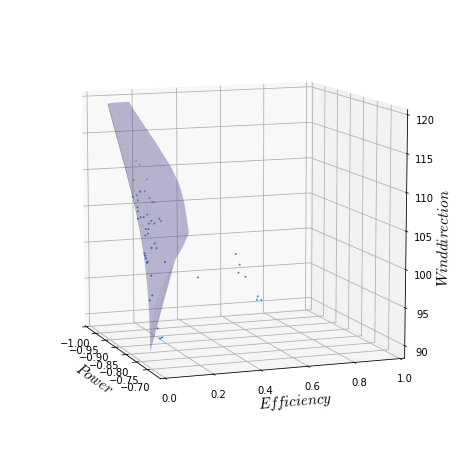

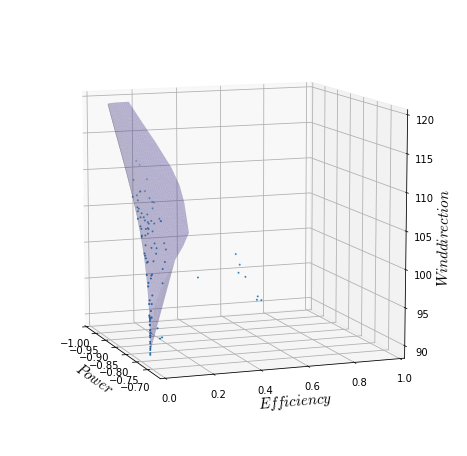

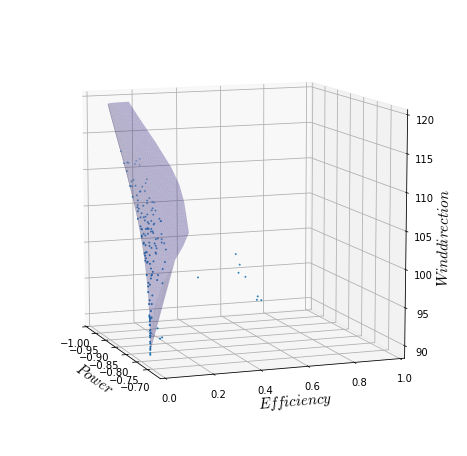

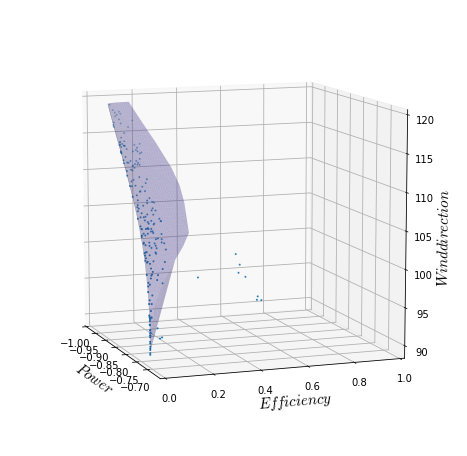

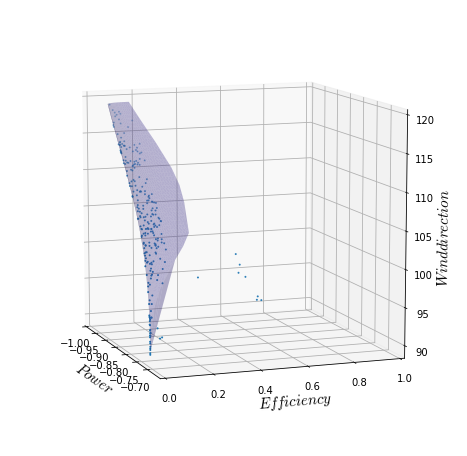

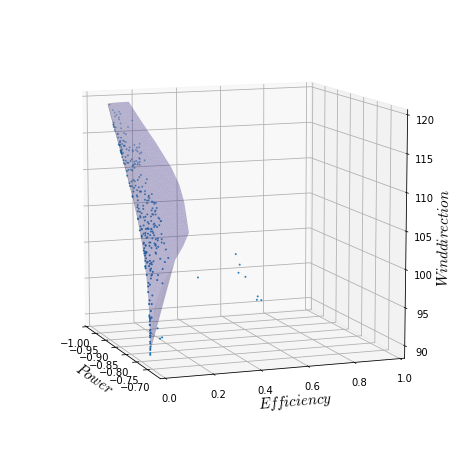

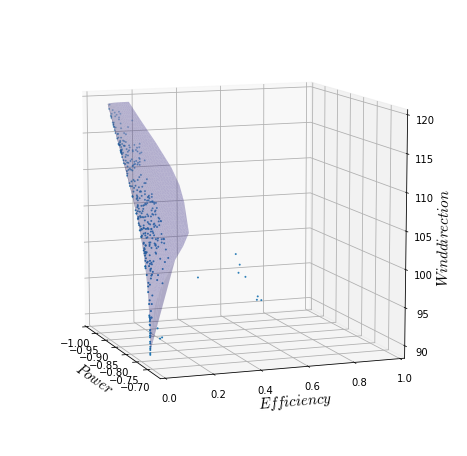

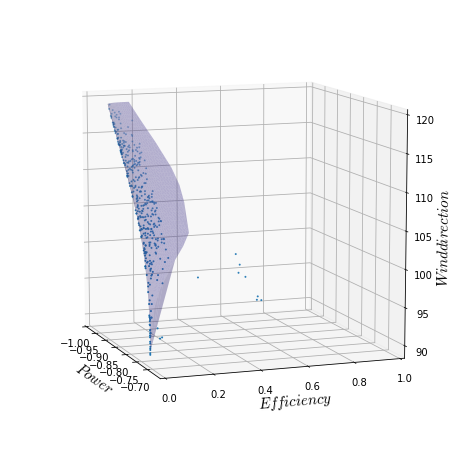

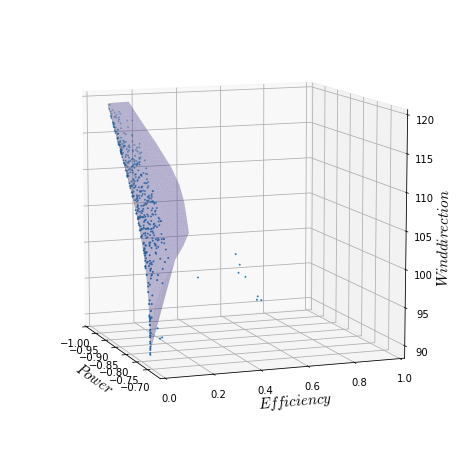

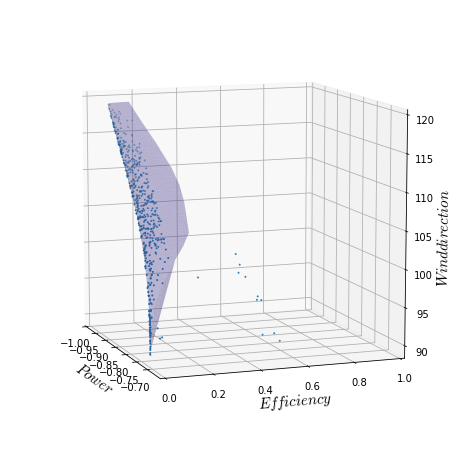

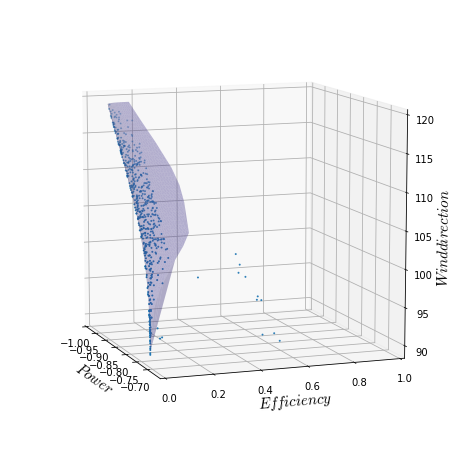

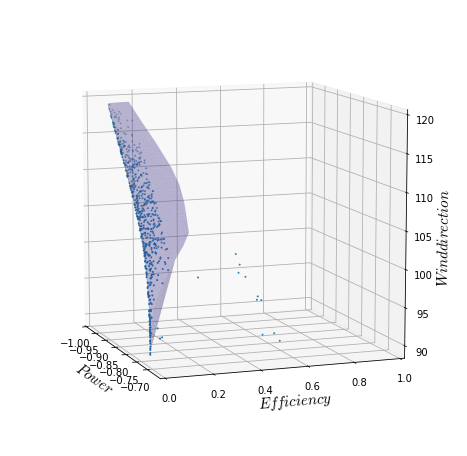

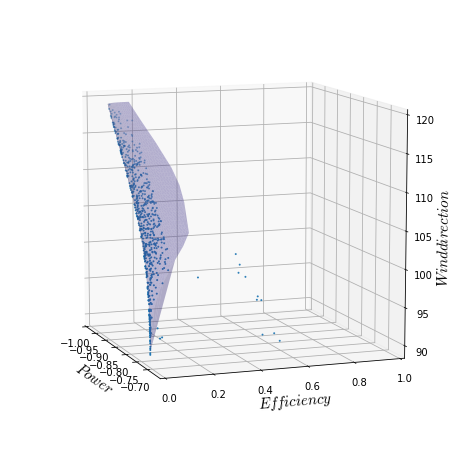

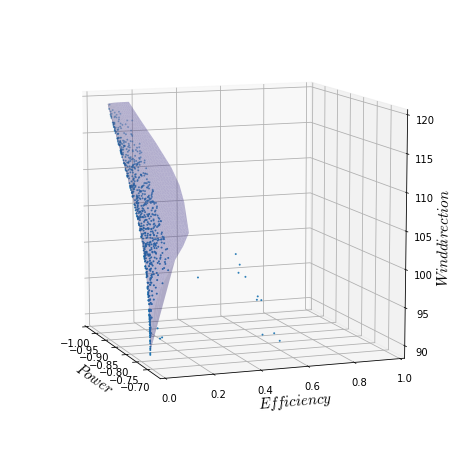

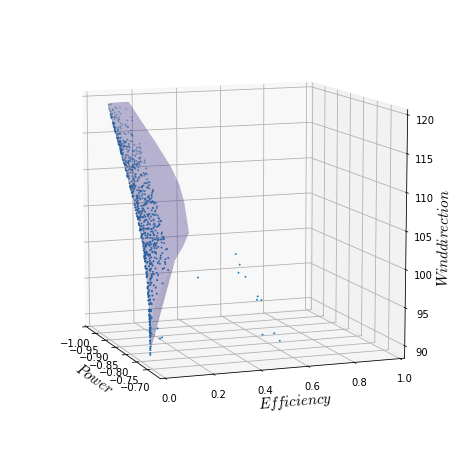

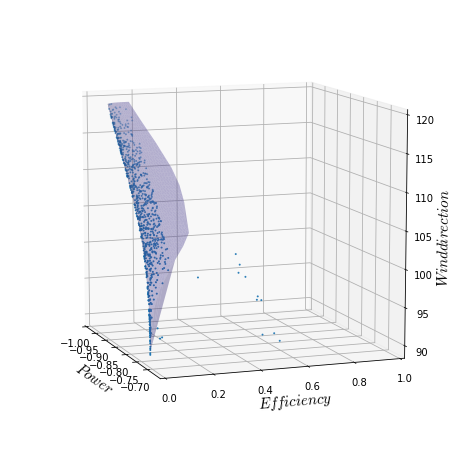

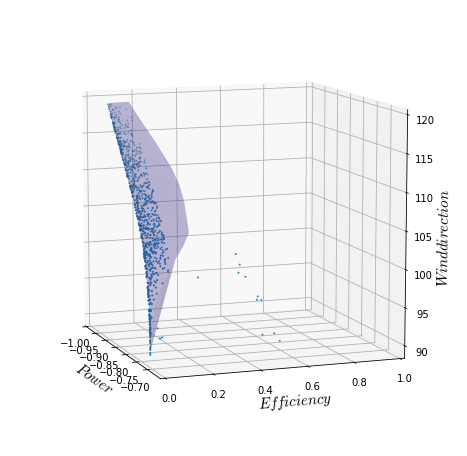

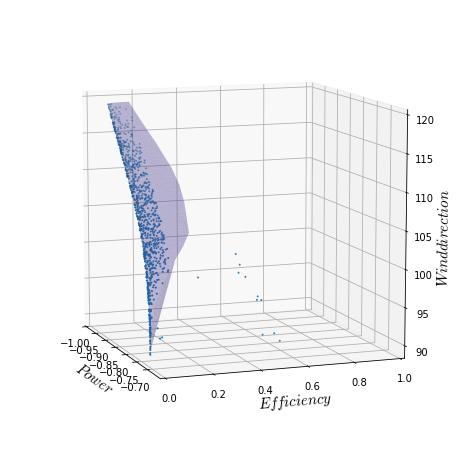

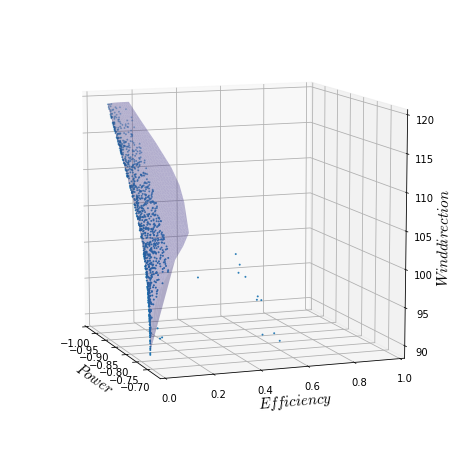

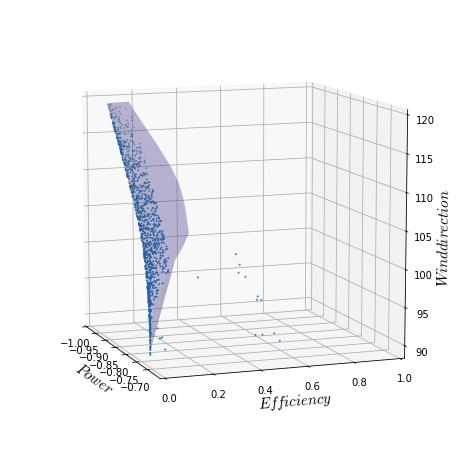

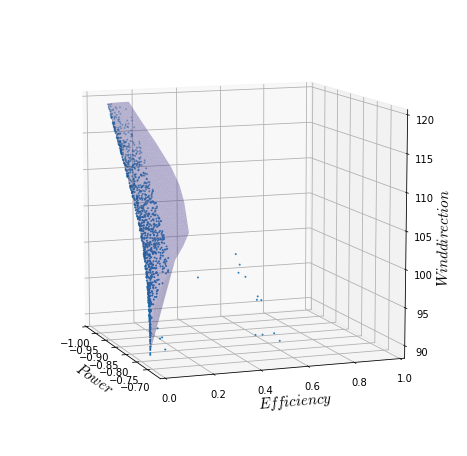

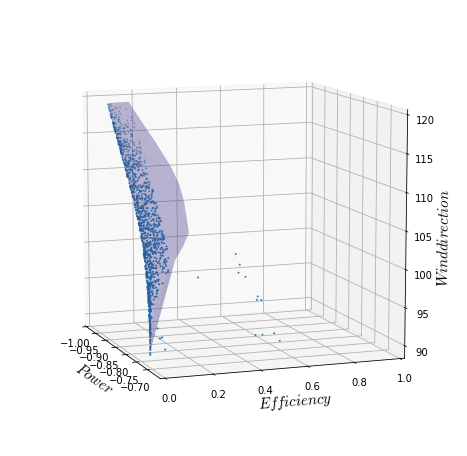

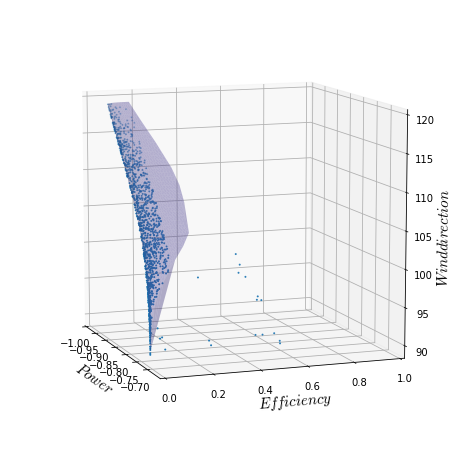

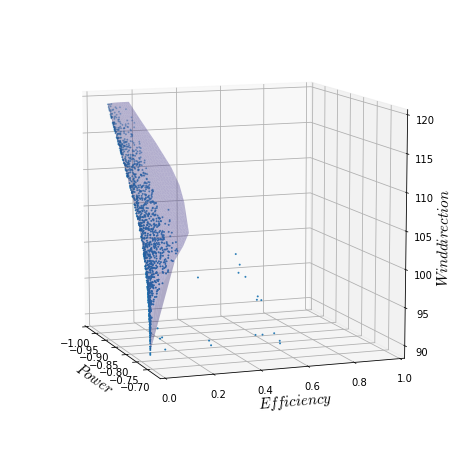

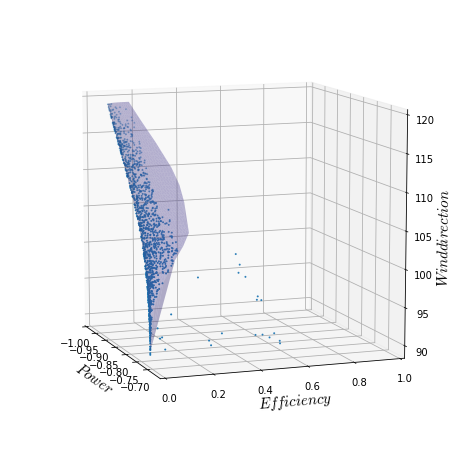

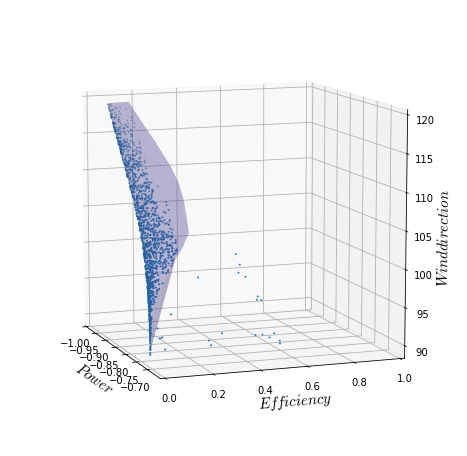

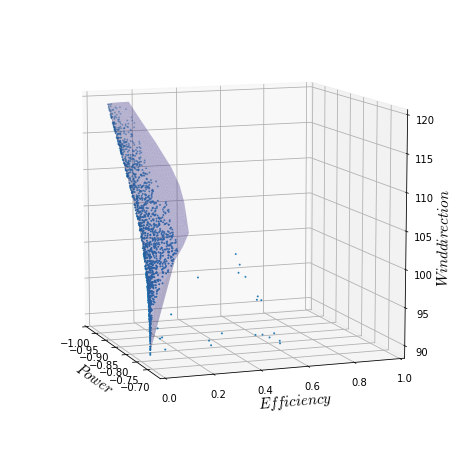

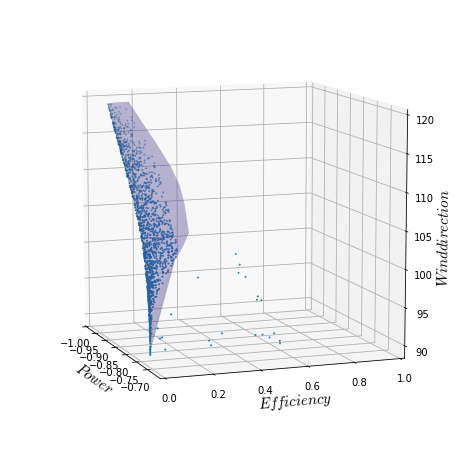

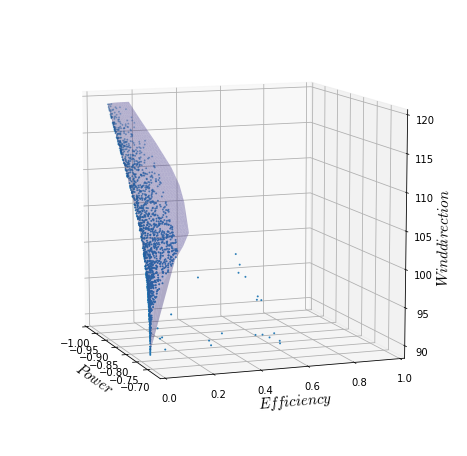

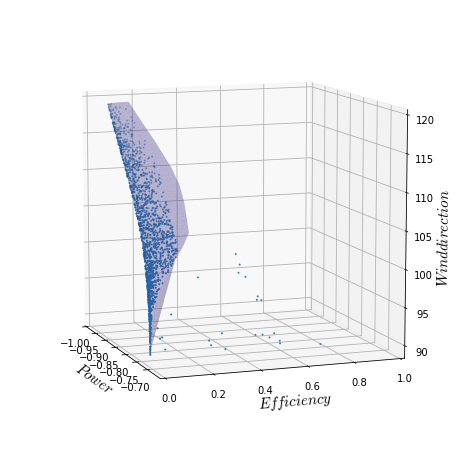

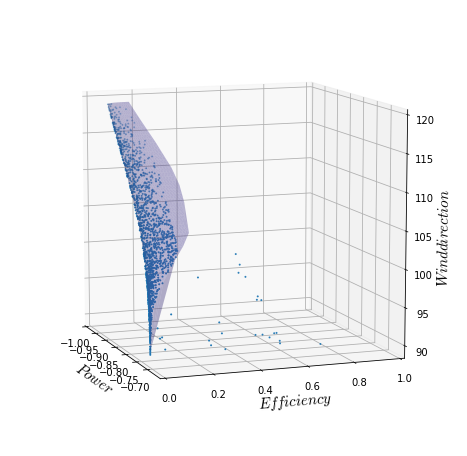

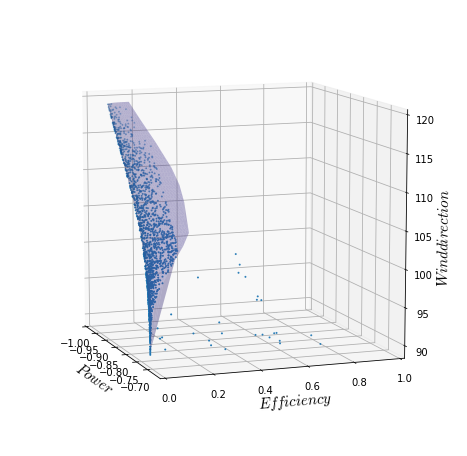

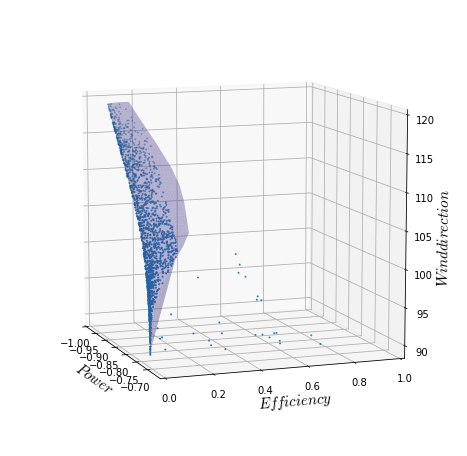

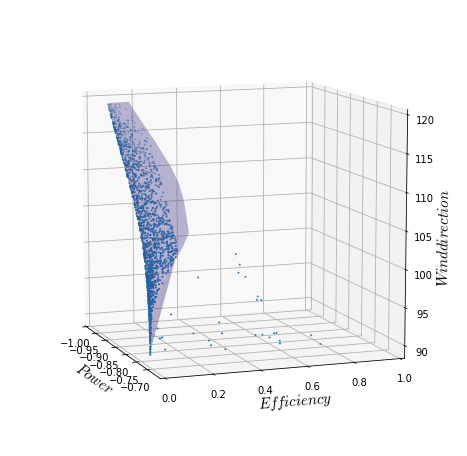

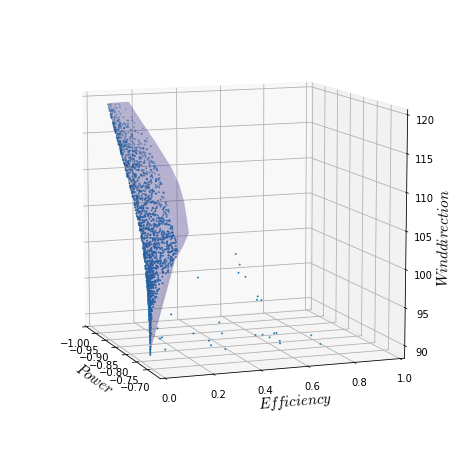

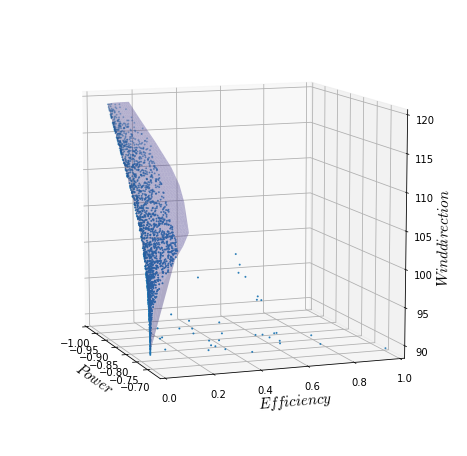

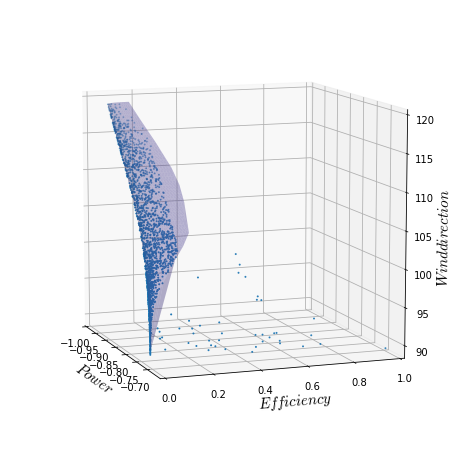

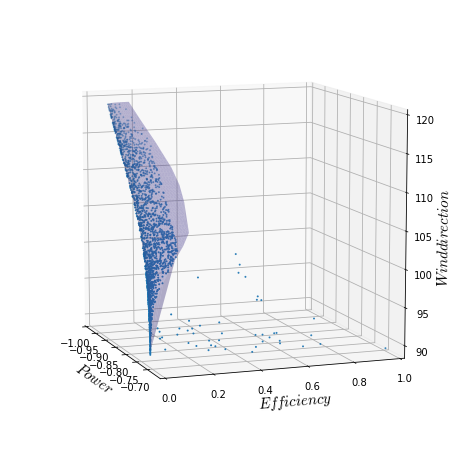

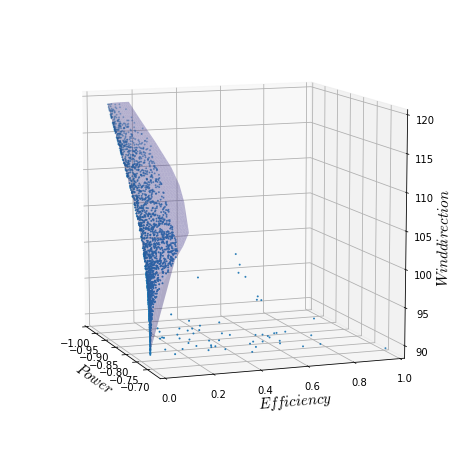

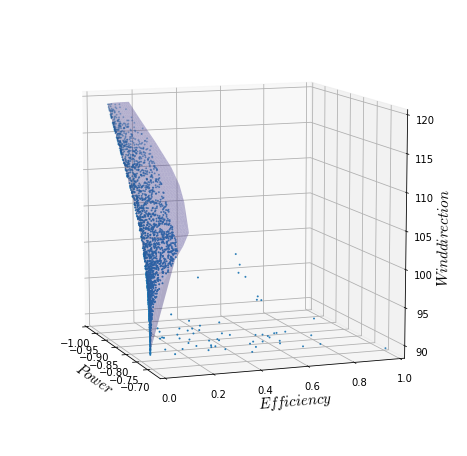

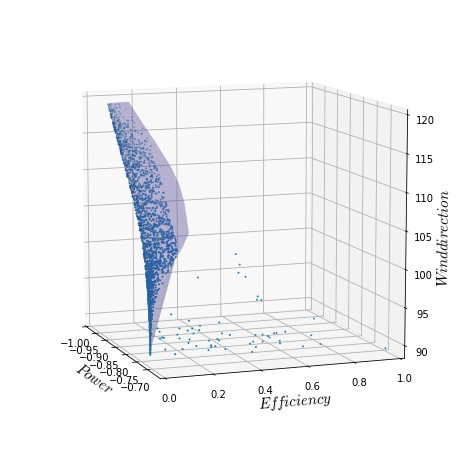

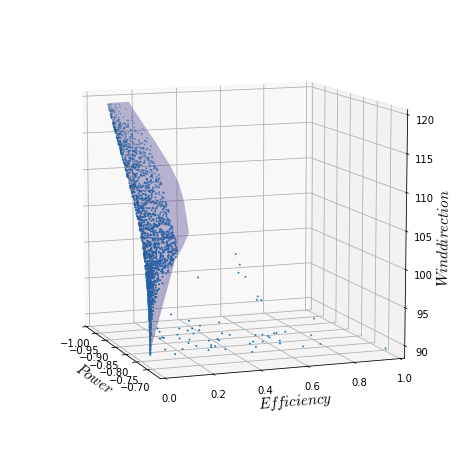

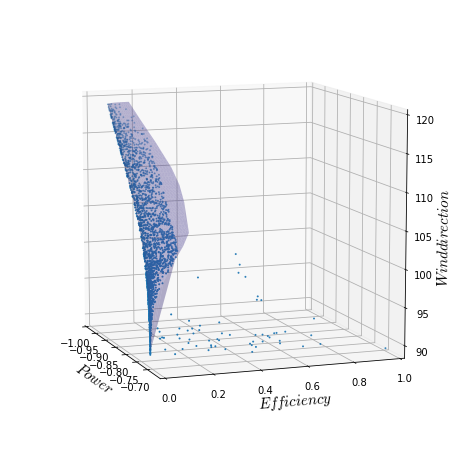

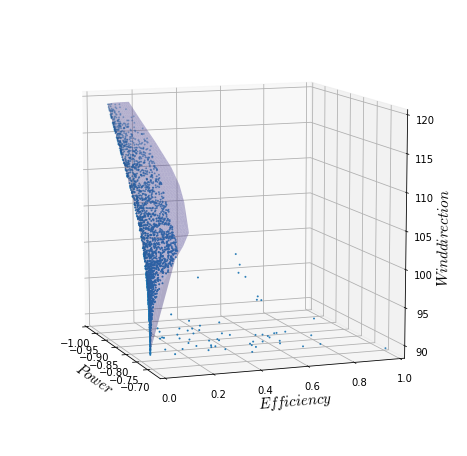

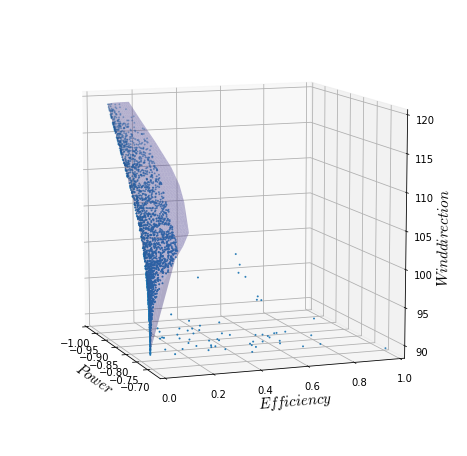

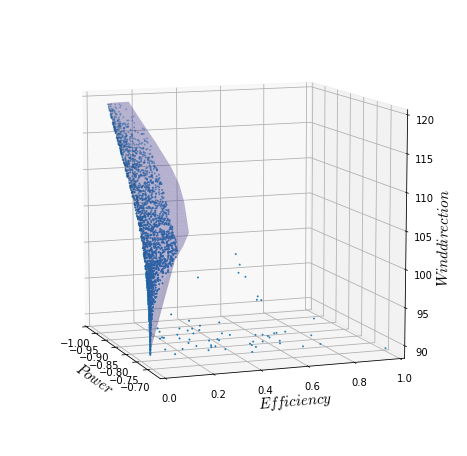

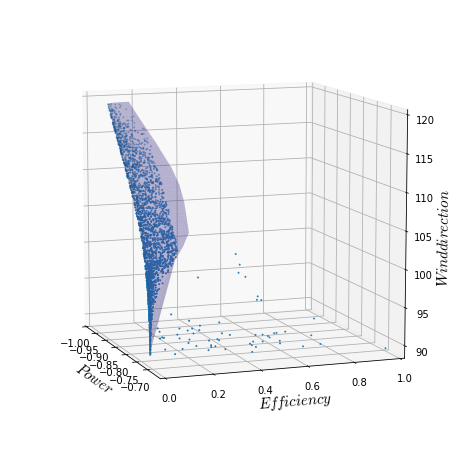

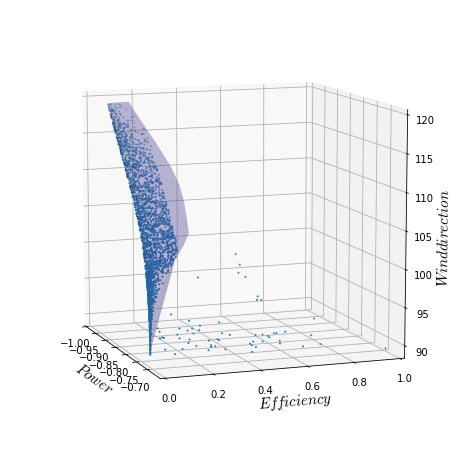

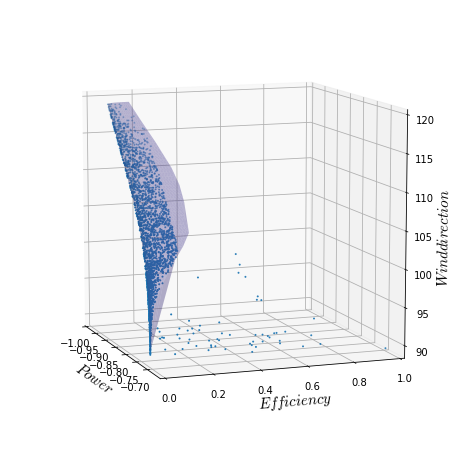

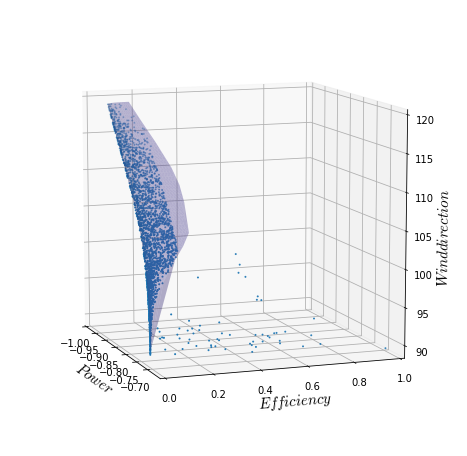

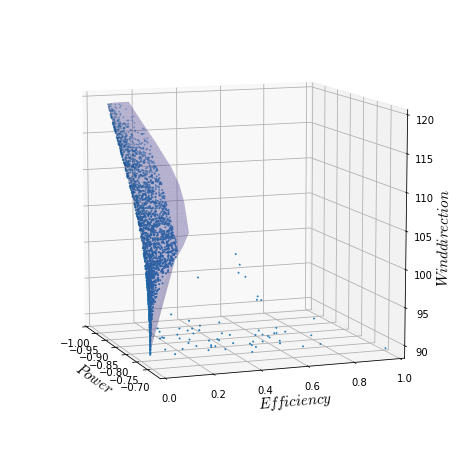

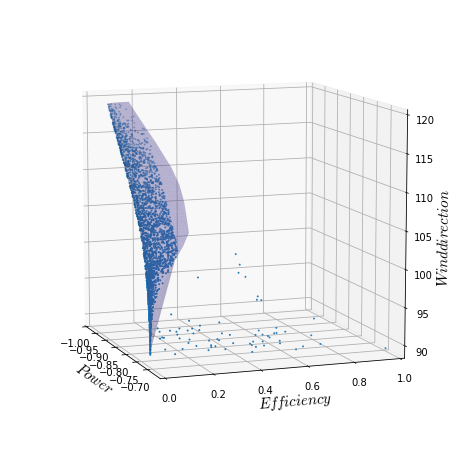

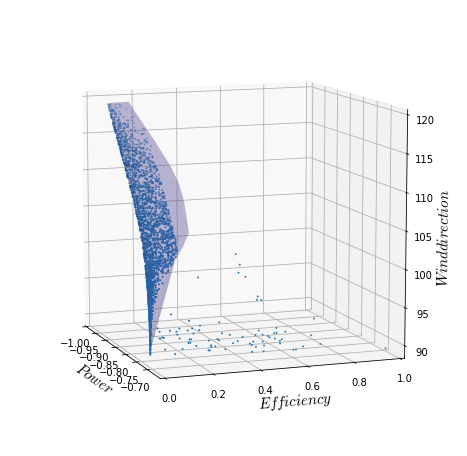

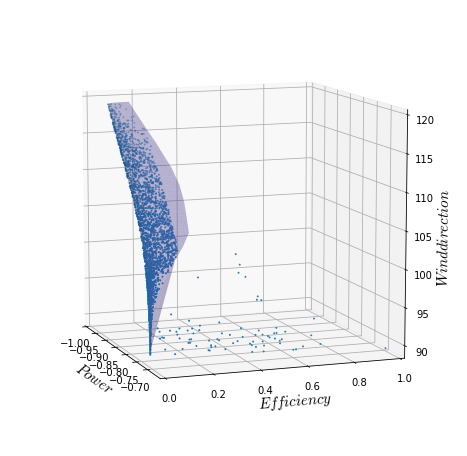

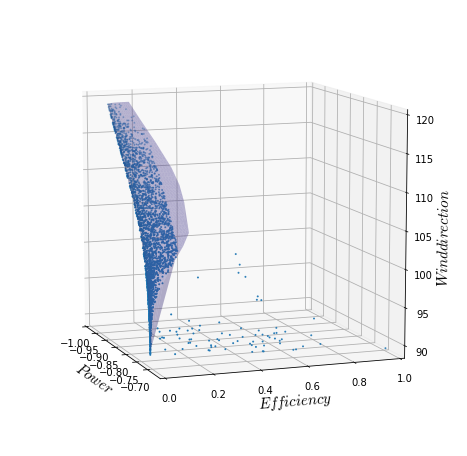

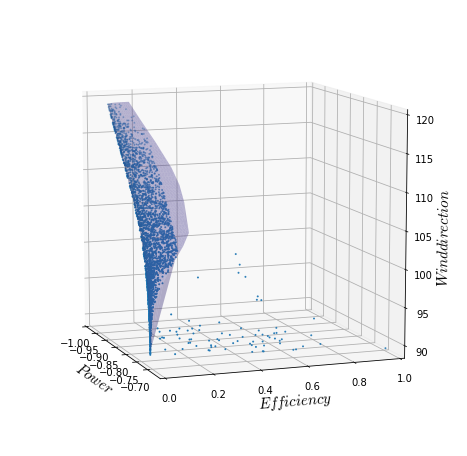

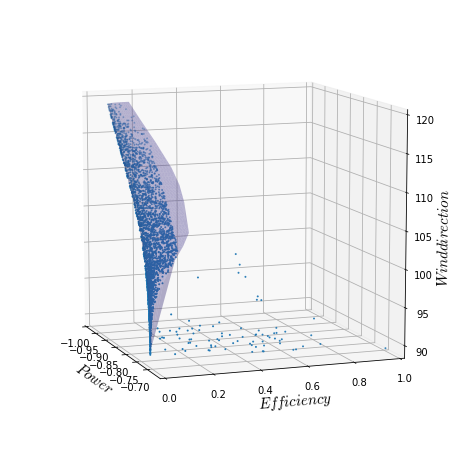

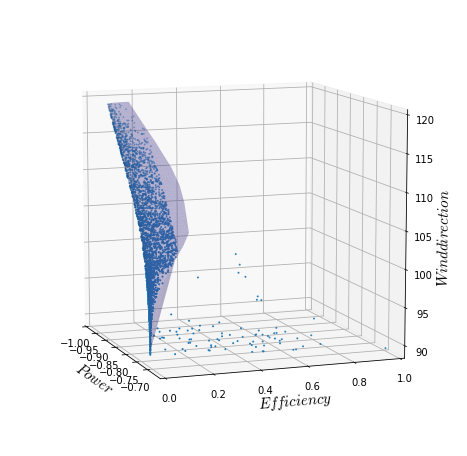

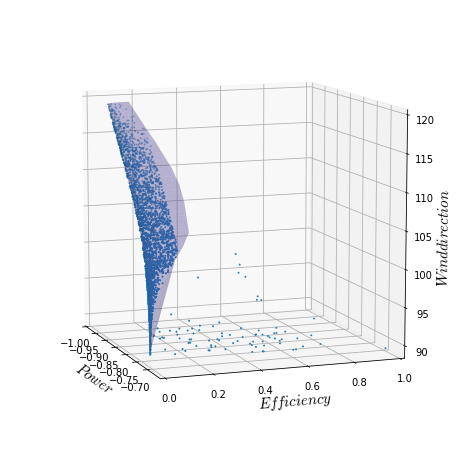

In [20]:
for i in range(0,3000,50):
    # Plot the surface
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4)
    ax.scatter(Y[:i+1,0], Y[:i+1,1], wd_context[:i+1], s=1, label = 'Selected pts')
    ax.view_init(azim=340, elev=10)
    ax.set_xlabel('$Power$', fontsize=15, rotation=150)
    ax.set_ylabel('$Efficiency$', fontsize=15)
    ax.set_zlabel('$Wind direction$', fontsize=15)
    ax.set_xlim([-1,-0.65])
    ax.set_ylim([0,1])
    ax.set_zlim([89,120])
    plt.savefig(str(i)+'png')
    plt.show()
   

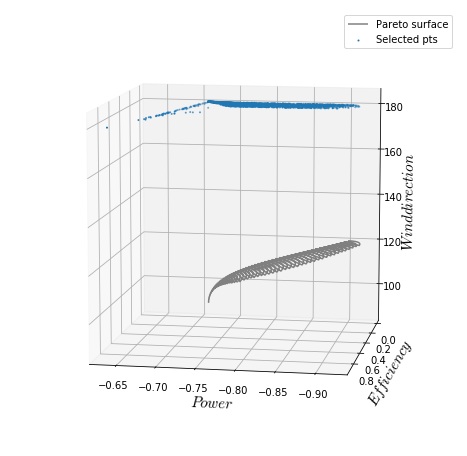

<Figure size 432x288 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(pareto_f1, pareto_f2, pareto_C, color='gray', label = 'Pareto surface')
ax.scatter(Y[:,0], Y[:,1], wd, s=1, label = 'Selected pts')
ax.view_init(azim=100, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=150)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
ax.legend()
plt.show()
plt.savefig('surface2.png')
plt.show()

0


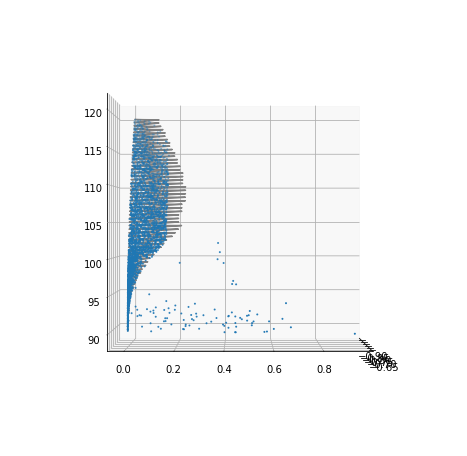

10


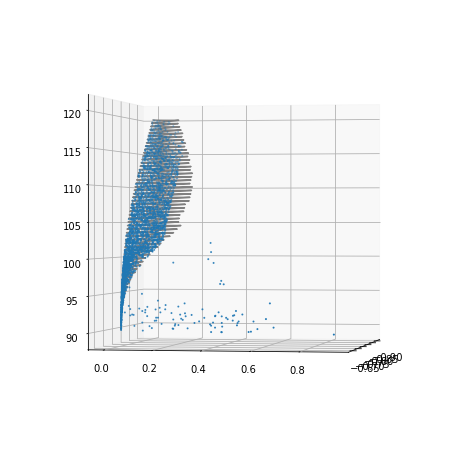

20


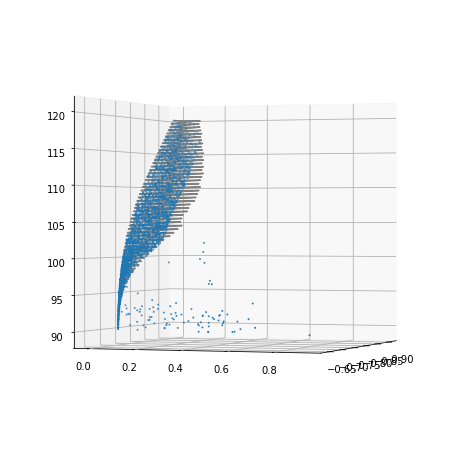

30


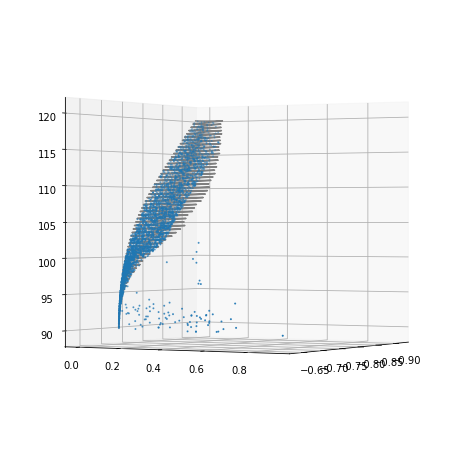

40


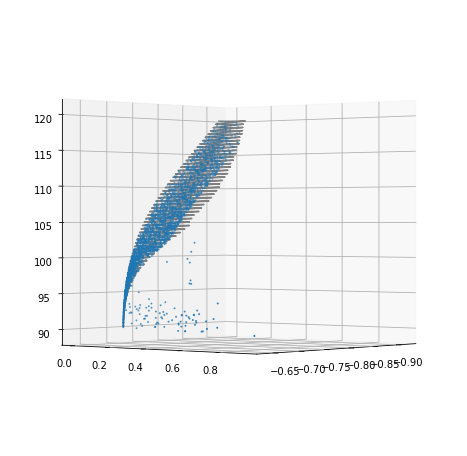

50


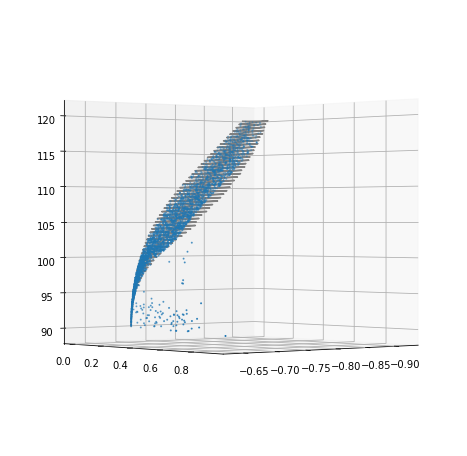

60


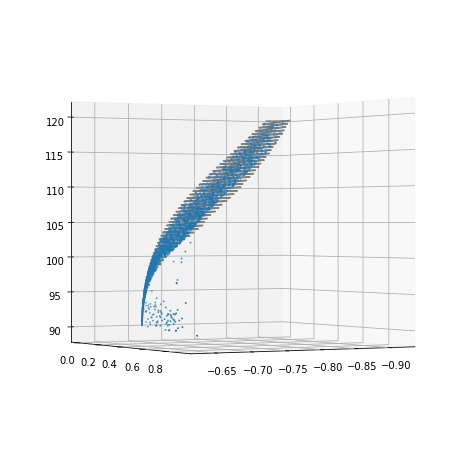

70


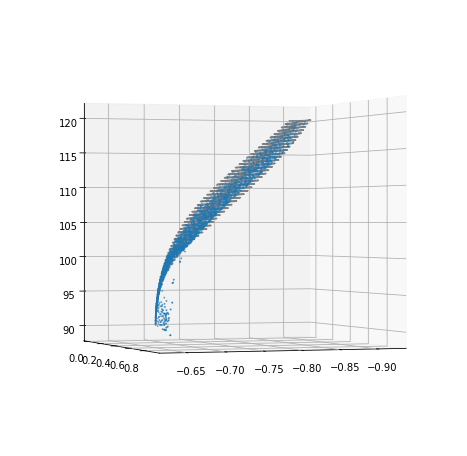

80


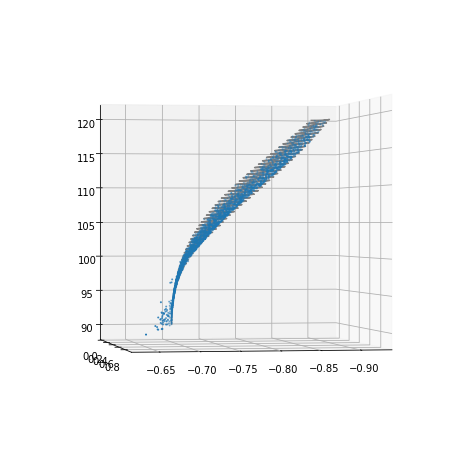

90


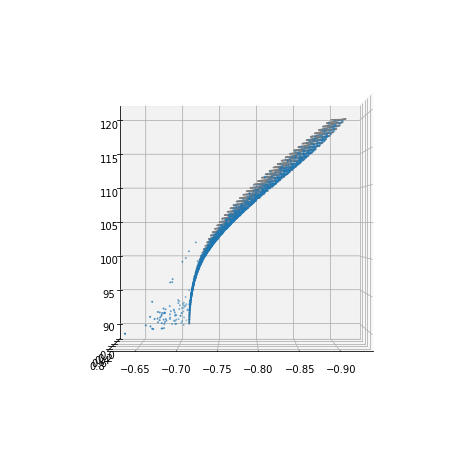

100


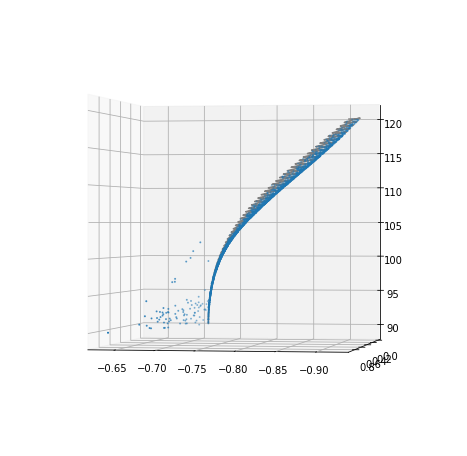

110


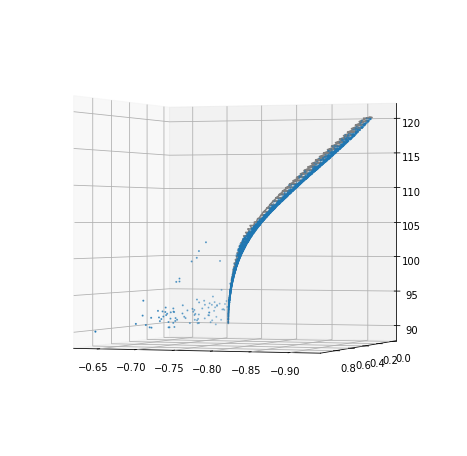

120


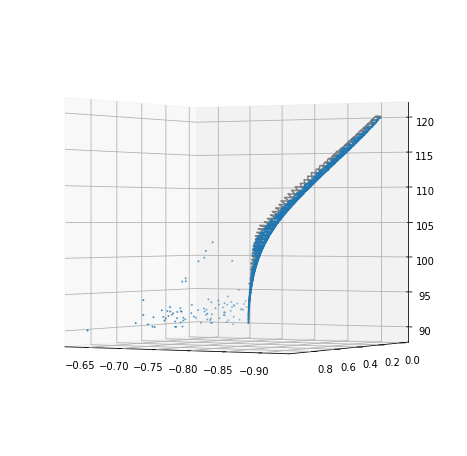

130


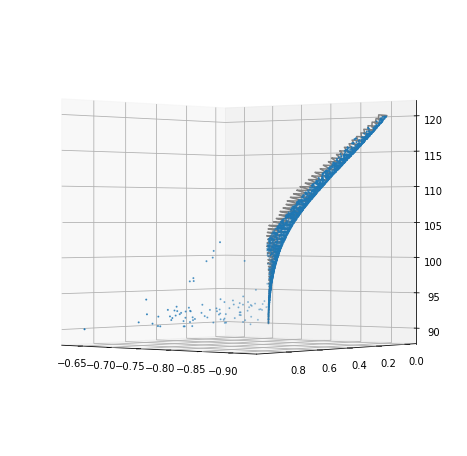

140


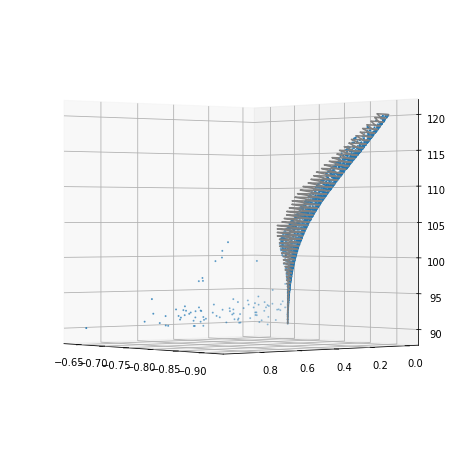

150


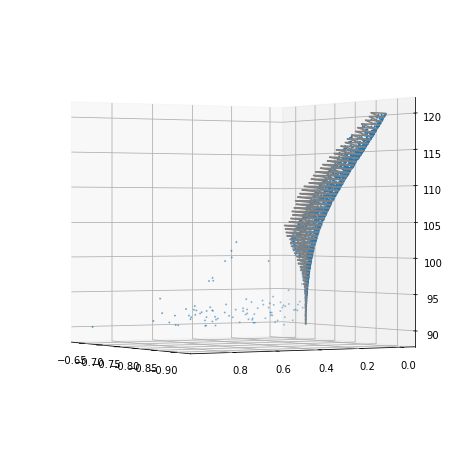

160


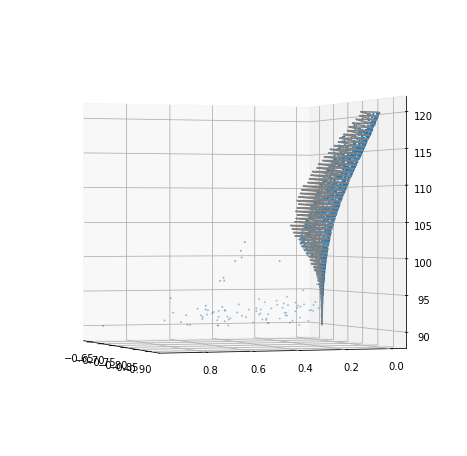

170


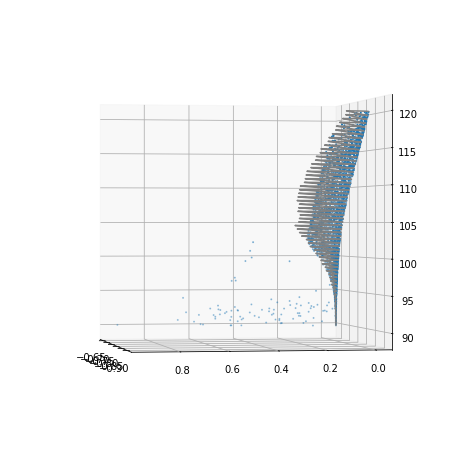

180


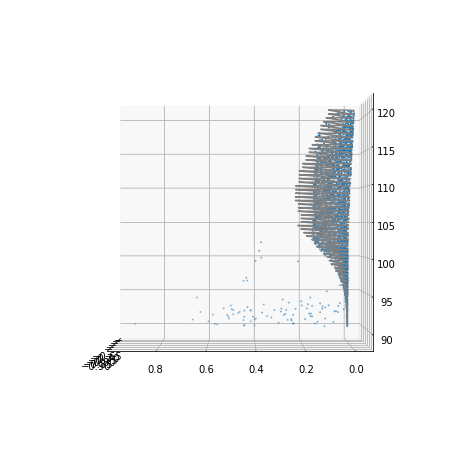

190


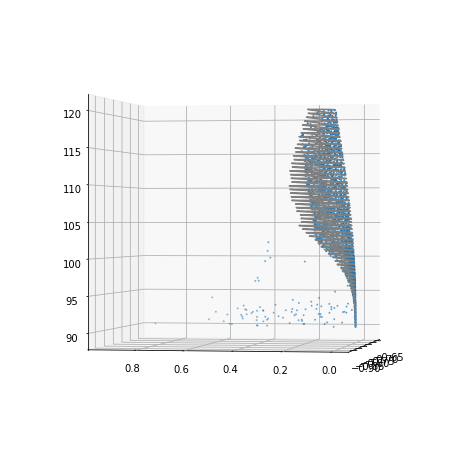

200


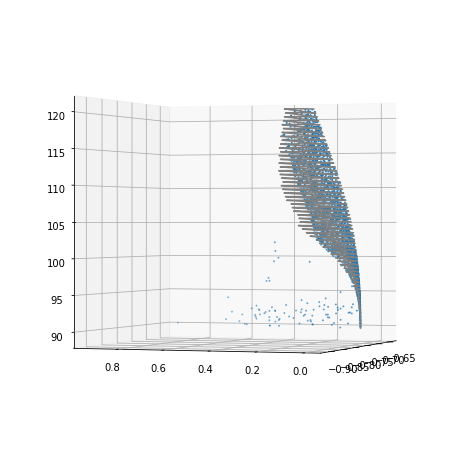

210


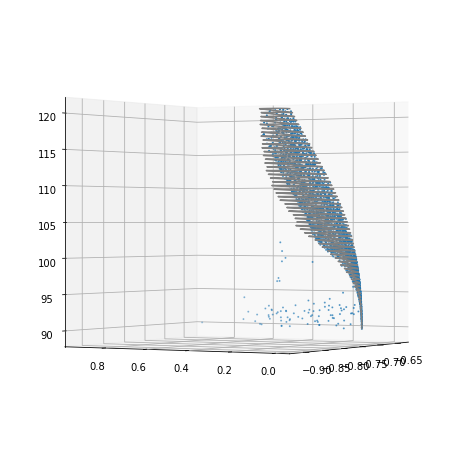

220


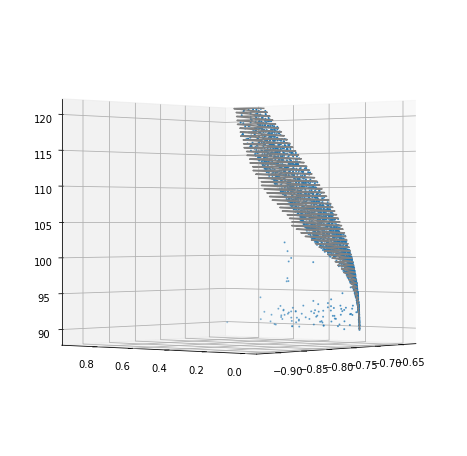

230


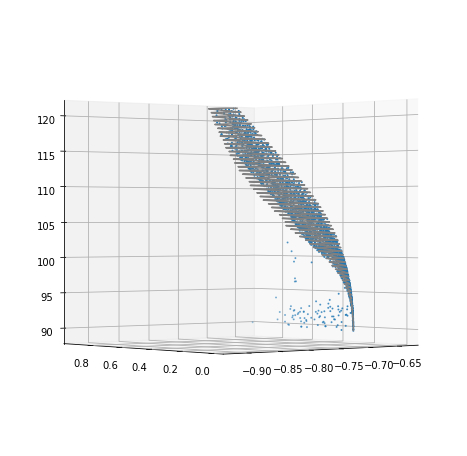

240


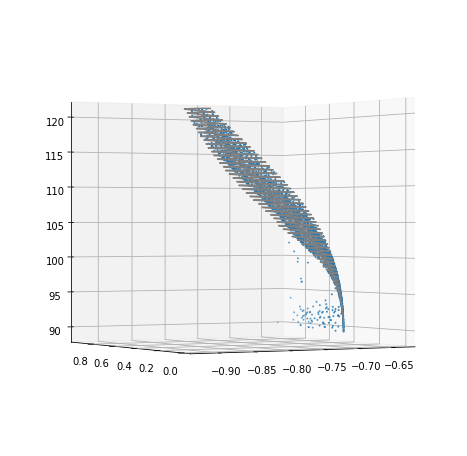

250


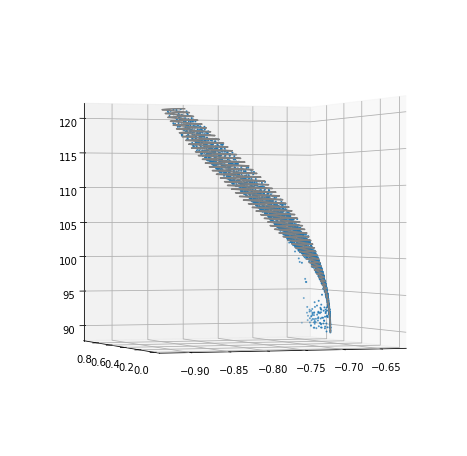

260


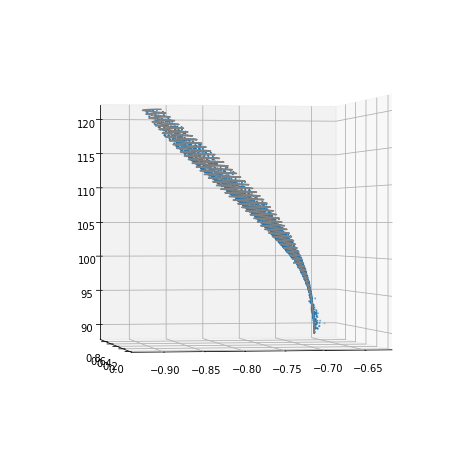

270


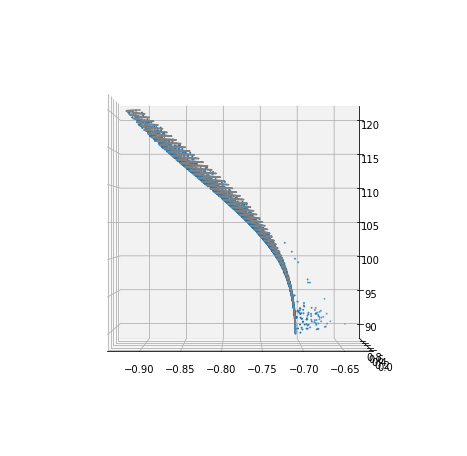

280


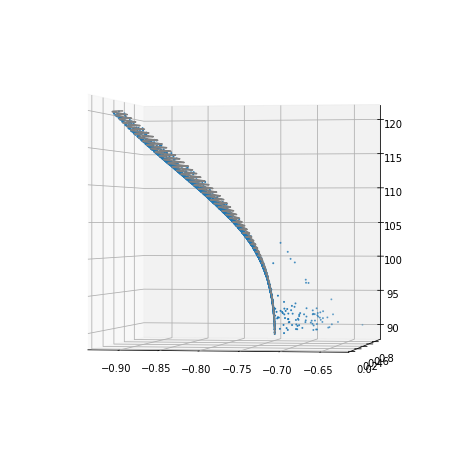

290


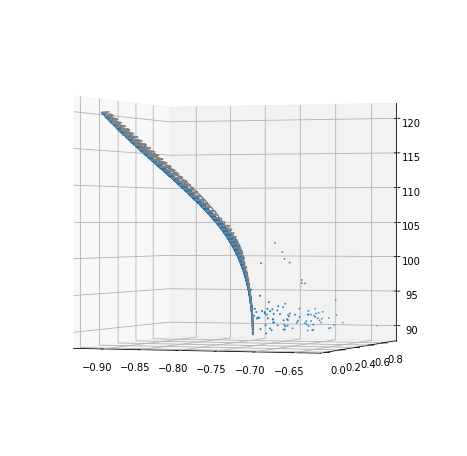

300


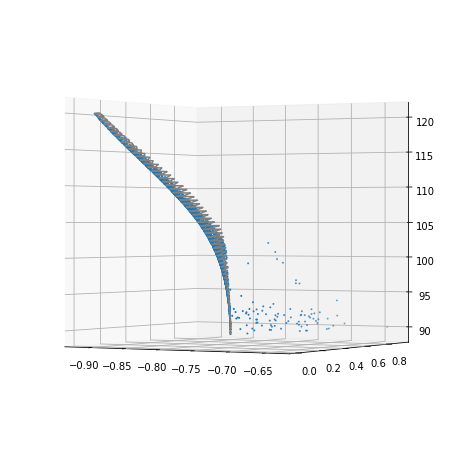

310


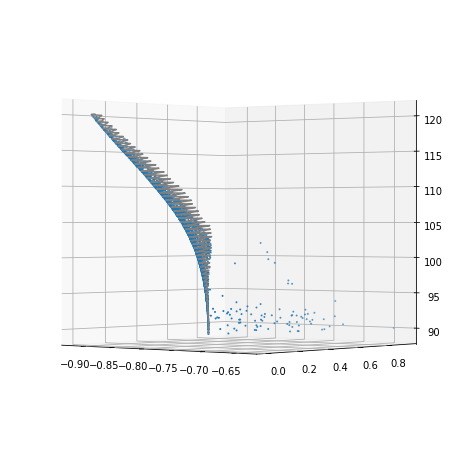

320


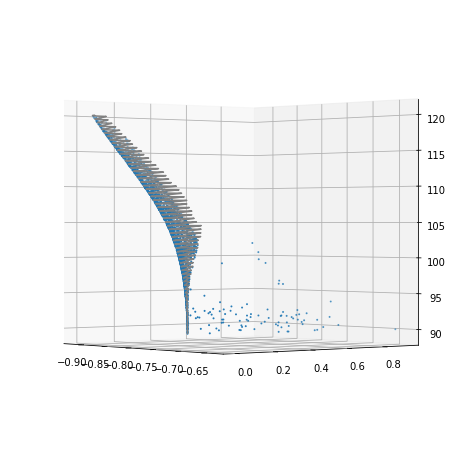

330


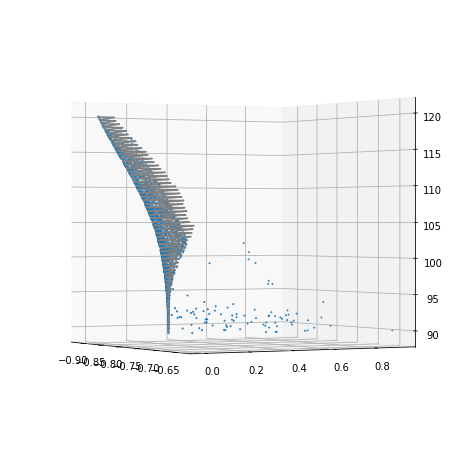

340


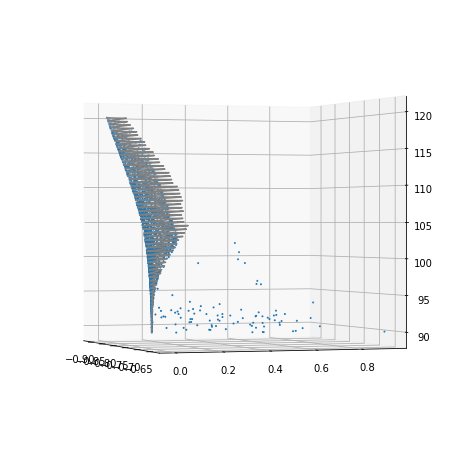

350


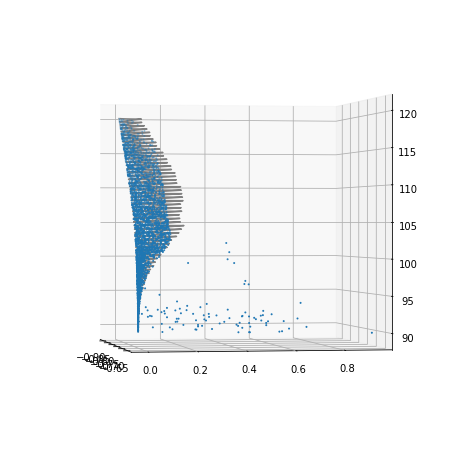

In [22]:
for i in range(0,360,10):
    print(i)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(pareto_f1, pareto_f2, pareto_C, color='gray')
    ax.scatter(Y[:,0], Y[:,1], wd_context, s=1)
    ax.view_init(azim=i, elev=0)
    plt.show()

In [23]:
plt.show()

In [24]:
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='b')
ax.scatter(Y[:,0], Y[:,1], wd)
plt.show()

In [25]:
pareto_f1

array([[-0.70942811],
       [-0.70946646],
       [-0.70946021],
       ...,
       [-0.90258915],
       [-0.90106339],
       [-0.8994772 ]])

In [26]:
opt_x = []
opt_y = []
for c in np.linspace(-1,0,1001):
    test_X = np.linspace(-3,3,1001)
    test_Y = np.ones(len(cont_X)) * c
    
    pareto = Pareto(np.empty((0,2)))
    f_value = multi_func(np.hstack((test_X[:,None], test_Y[:,None])))
    pareto.update(f_value)
    
    idx = np.array([i for i in range(len(f_value)) if f_value[i,0] in pareto.front[:,0] and f_value[i,1] in pareto.front[:,1]])
    opt_x.extend(test_X[idx])
    opt_y.extend(test_Y[idx])

plt.xlim([-np.pi,np.pi])
plt.scatter(opt_x, opt_y, marker = 's', color = 'red')
plt.show()

NameError: name 'cont_X' is not defined